In [1]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [2]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [3]:
df = load_csv()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [5]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [6]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

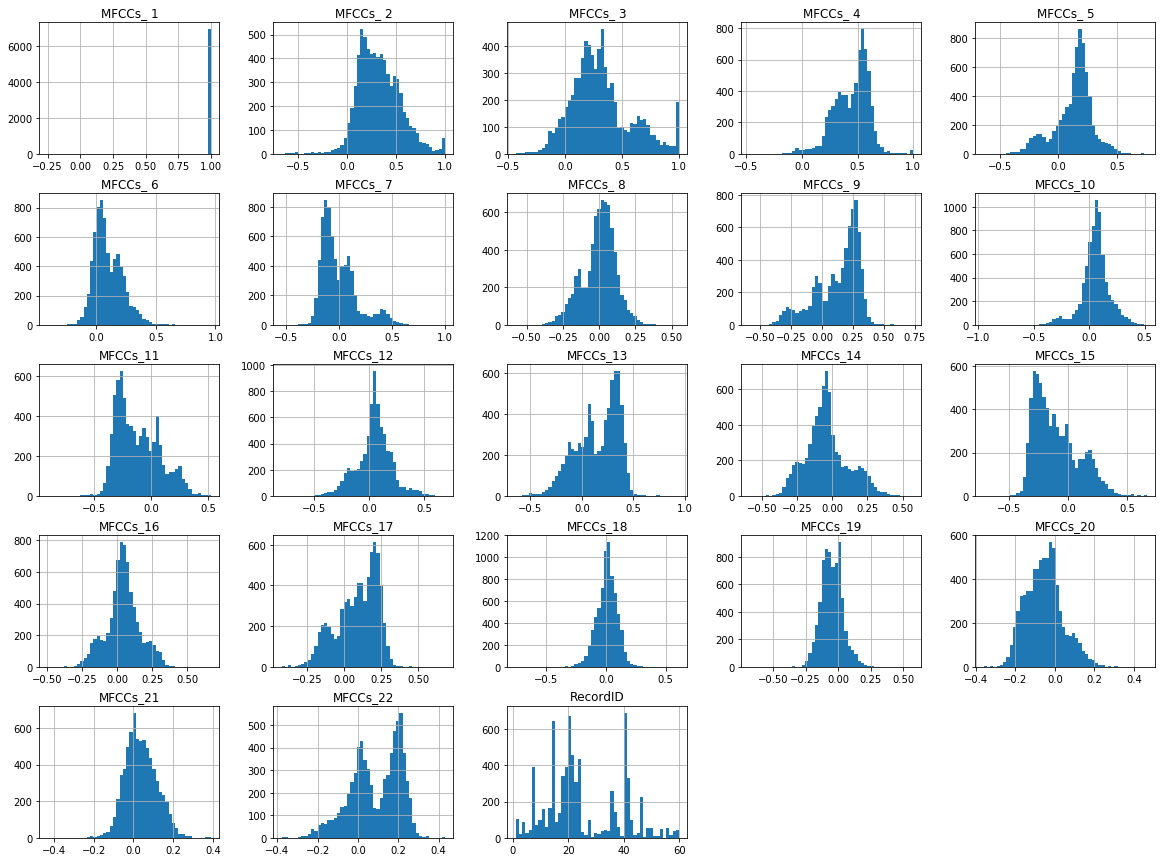

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Right now only choosing species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [9]:
from imblearn.under_sampling import RandomUnderSampler

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)

print(str(X_resampled.size))
print(str(Y_resampled.size))

print(str(X.size))
print(str(Y.size))

print(pd.value_counts(Y_resampled))

106436
4838
158290
7195
AdenomeraHylaedactylus    1121
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
dtype: int64


In [10]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [176]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        #val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        #val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        # print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

In [217]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def createModel():
    model = Sequential()

    model.add(Dense(units=32, activation='relu', input_dim=22))
    model.add(Dense(units=64, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [301]:
from sklearn.metrics import classification_report

N_EPOCHS = 25
BATCH_SIZE = 32

metrics = []

def trainAndTestModel(model, x_train, y_train, x_val, y_val):
    
    # Create new callback class
    metrics.append(Metrics())
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, callbacks=[metrics[-1]])
    
    pred = model.predict(x_val, batch_size=32, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    
    report = classification_report(argmax(y_val, axis=1), y_pred)
    
    #TODO: see if we need this
    #report = pandas_classification_report(np.argmax(y_val, axis=1), y_pred)
    
    mFeature = metricsByFeature(argmax(y_val, axis=1), y_pred)
    featuresMetrics.append(mFeature)
    
    print(report)
    
    return history 

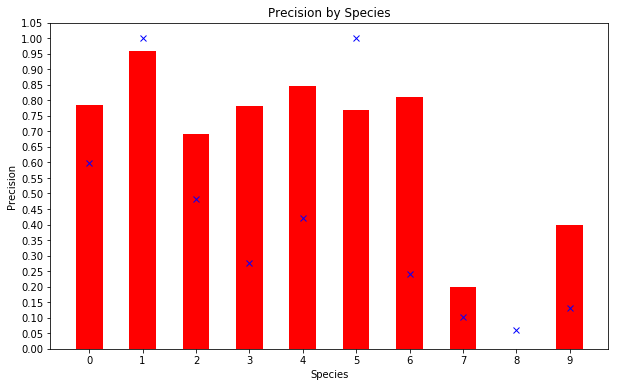

In [406]:
featuresMetrics[0]

def plotPrecisionByFeature(values):
    plt.figure(4)
    
    precisionSum = np.zeros(10) #Number of features (species)
    supportSum = np.zeros(10) #Number of features (species)
    
    for val in values:
        precisionSum += val['precision']
        supportSum += val['support']
        
    avgPrecision = precisionSum / 5 # Number of folds
    avgSupport = supportSum / 5 # Number of folds
    
    avgSupport = avgSupport / avgSupport.max()
    
    plt.xticks(np.arange(0, 10, 1.0))
    plt.yticks(np.arange(0, 1.1, 0.05))
    
    plt.xlabel("Species")
    plt.ylabel("Precision")
    plt.title("Precision by Species") 
    
    for index, val in enumerate(avgPrecision):
        plt.bar(index, val, width=0.5, color='red')
        
    for index, val in enumerate(avgSupport):
        plt.plot(index, val, 'xb')
        
    plt.show()
    
plotPrecisionByFeature(featuresMetrics)

    


In [332]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

np.random.seed(0)

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

def metricsByFeature(y_true, y_pred):
        metricsSummary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)
        
        finalMetrics = {
            'precision': metricsSummary[0],
            'recall': metricsSummary[1],
            'f1-score': metricsSummary[2],
            'support': metricsSummary[3]
        }
        
        return finalMetrics


In [335]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

historyList = []
featuresMetrics = []
metrics = []
#reportList = []

for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = trainAndTestModel(model, xtrain, ytrain, xval, yval)
    
    historyList.append(history)
    

Train on 3866 samples, validate on 972 samples
Epoch 1/25
3866/3866 [==============================] - 8s 2ms/step - loss: 2.1796 - acc: 0.2307 - val_loss: 2.0751 - val_acc: 0.2315
 — val_f1: 0.096451 — val_precision: 0.060916 — val_recall 0.231481
Epoch 2/25
1056/3866 [=======>......................] - ETA: 0s - loss: 2.0526 - acc: 0.2282

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3866/3866 [==============================] - 1s 216us/step - loss: 1.9842 - acc: 0.2318 - val_loss: 1.9015 - val_acc: 0.2346
 — val_f1: 0.111513 — val_precision: 0.073792 — val_recall 0.234568
Epoch 3/25
3866/3866 [==============================] - 1s 173us/step - loss: 1.8328 - acc: 0.3334 - val_loss: 1.7693 - val_acc: 0.4198
 — val_f1: 0.284080 — val_precision: 0.221615 — val_recall 0.419753
Epoch 4/25
3866/3866 [==============================] - 1s 279us/step - loss: 1.7056 - acc: 0.4462 - val_loss: 1.6445 - val_acc: 0.4547
 — val_f1: 0.326100 — val_precision: 0.491943 — val_recall 0.454733
Epoch 5/25
3866/3866 [==============================] - 1s 316us/step - loss: 1.5821 - acc: 0.5021 - val_loss: 1.5241 - val_acc: 0.5350
 — val_f1: 0.436975 — val_precision: 0.488488 — val_recall 0.534979
Epoch 6/25
3866/3866 [==============================] - 1s 248us/step - loss: 1.4674 - acc: 0.5546 - val_loss: 1.4156 - val_acc: 0.5813
 — val_f1: 0.492141 — val_precision: 0.476045 — val_recall 

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 3868 samples, validate on 970 samples
Epoch 1/25
3868/3868 [==============================] - 8s 2ms/step - loss: 2.1770 - acc: 0.2528 - val_loss: 2.0835 - val_acc: 0.2454
 — val_f1: 0.115195 — val_precision: 0.108729 — val_recall 0.245361
Epoch 2/25
3868/3868 [==============================] - 1s 182us/step - loss: 2.0111 - acc: 0.2616 - val_loss: 1.9471 - val_acc: 0.2887
 — val_f1: 0.174384 — val_precision: 0.125361 — val_recall 0.288660
Epoch 3/25
3868/3868 [==============================] - 1s 183us/step - loss: 1.8904 - acc: 0.4170 - val_loss: 1.8339 - val_acc: 0.4546
 — val_f1: 0.315085 — val_precision: 0.257990 — val_recall 0.454639
Epoch 4/25
3868/3868 [==============================] - 1s 181us/step - loss: 1.7743 - acc: 0.4581 - val_loss: 1.7147 - val_acc: 0.4608
 — val_f1: 0.323890 — val_precision: 0.403274 — val_recall 0.460825
Epoch 5/25
3868/3868 [==============================] - 1s 220us/step - loss: 1.6511 - acc: 0.5054 - val_loss: 1.5890 - val_acc: 0.5289
 — 

 — val_f1: 0.667875 — val_precision: 0.654315 — val_recall 0.740434
Epoch 13/25
3871/3871 [==============================] - 1s 239us/step - loss: 0.8579 - acc: 0.7409 - val_loss: 0.8450 - val_acc: 0.7497
 — val_f1: 0.683507 — val_precision: 0.674603 — val_recall 0.749741
Epoch 14/25
3871/3871 [==============================] - 1s 244us/step - loss: 0.8201 - acc: 0.7448 - val_loss: 0.8090 - val_acc: 0.7549
 — val_f1: 0.692865 — val_precision: 0.681709 — val_recall 0.754912
Epoch 15/25
3871/3871 [==============================] - 1s 230us/step - loss: 0.7858 - acc: 0.7476 - val_loss: 0.7761 - val_acc: 0.7632
 — val_f1: 0.701672 — val_precision: 0.686696 — val_recall 0.763185
Epoch 16/25
3871/3871 [==============================] - 1s 227us/step - loss: 0.7548 - acc: 0.7528 - val_loss: 0.7451 - val_acc: 0.7704
 — val_f1: 0.710975 — val_precision: 0.689557 — val_recall 0.770424
Epoch 17/25
3871/3871 [==============================] - 1s 239us/step - loss: 0.7256 - acc: 0.7536 - val_loss: 

3873/3873 [==============================] - 1s 180us/step - loss: 0.6617 - acc: 0.7738 - val_loss: 0.6598 - val_acc: 0.7731
 — val_f1: 0.733083 — val_precision: 0.729270 — val_recall 0.773057
Epoch 25/25
3873/3873 [==============================] - 1s 178us/step - loss: 0.6400 - acc: 0.7883 - val_loss: 0.6394 - val_acc: 0.7720
 — val_f1: 0.730445 — val_precision: 0.734920 — val_recall 0.772021
             precision    recall  f1-score   support

          0       0.71      0.82      0.76       134
          1       0.94      1.00      0.97       224
          2       0.62      0.65      0.63       108
          3       0.69      0.29      0.41        62
          4       0.93      0.94      0.93        94
          5       0.68      0.98      0.81       224
          6       1.00      0.30      0.46        54
          7       0.00      0.00      0.00        23
          8       0.00      0.00      0.00        13
          9       0.00      0.00      0.00        29

avg / total      

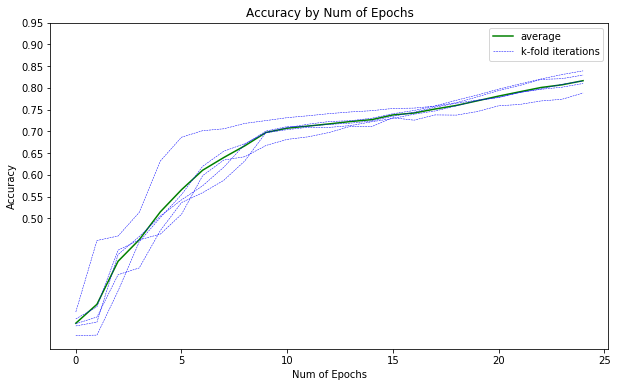

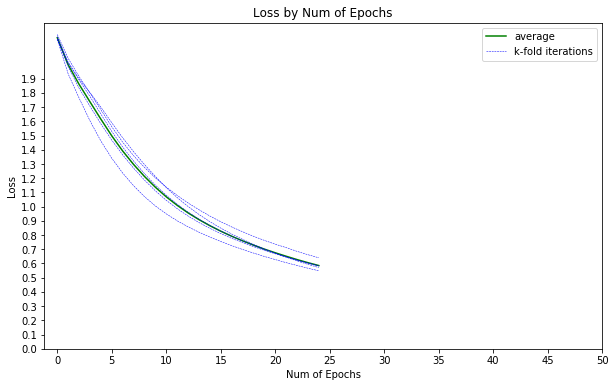

In [345]:
# idk why but it doesn't work inside the function
plt.rcParams['figure.figsize'] = (10, 6)

plotAccuracy(historyList)
plotLoss(historyList)


In [293]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotAccuracy(results):
    plt.figure(0)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['acc']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['acc'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.5, 1.0, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")

    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['loss']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['loss'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0, 2, 0.1))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")

    plt.show()
    

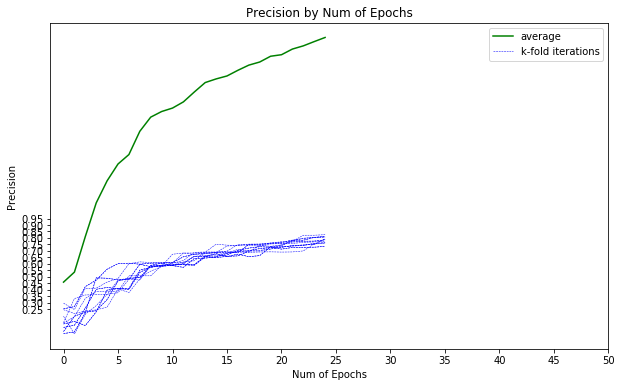

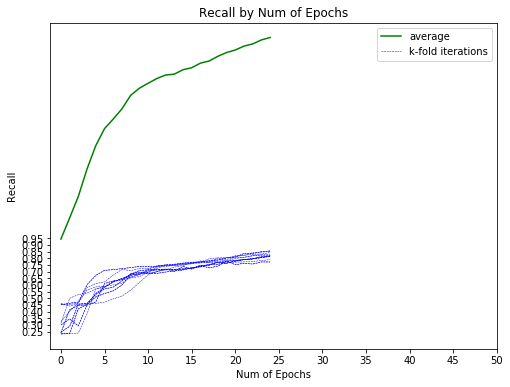

In [344]:
def plotPrecision(metrics):
    plt.figure(2)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_precisions
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_precisions, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
       
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Precision")
    plt.title("Precision by Num of Epochs")
        
def plotRecall(metrics):
    plt.figure(3)
        
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_recalls
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_recalls, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
    
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Recall")
    plt.title("Recall by Num of Epochs")
    
plotPrecision(metrics)
plotRecall(metrics)
    
    

In [326]:
arr = np.array([1,2,3])
arr2 = np.array([1,2,3])



[(1, 1.) (2, 2.) (3, 3.)]
